In [1]:
# original: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import binarize
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold

from sklearn import set_config
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve


In [2]:
np.random.seed(0)

# LOAD DATA
from sklearn.datasets import fetch_openml 

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [3]:
df = pd.concat([X, y], axis=1)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


# Data exploration

In [4]:
df_stat1 = pd.DataFrame({'n_unique': df.nunique(), 'n_missing': df.isna().sum(), 'ratio_missing': df.isna().sum()/len(df)})
df_stat2 = df.describe()

print('Shape:', df.shape)
print('# duplicate:', df.duplicated(subset=None, keep='first').sum())
print()
df.info()
print()
print(df_stat1)
print()
print(df_stat2)

Shape: (1309, 14)
# duplicate: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null float64
name         1309 non-null object
sex          1309 non-null category
age          1046 non-null float64
sibsp        1309 non-null float64
parch        1309 non-null float64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null category
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
survived     1309 non-null category
dtypes: category(3), float64(6), object(5)
memory usage: 116.7+ KB

           n_unique  n_missing  ratio_missing
pclass            3          0       0.000000
name           1307          0       0.000000
sex               2          0       0.000000
age              98        263       0.200917
sibsp             7          0       0.000000
parch             8          0 

# Split data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=42)

# training data
X_train = pd.DataFrame(data=X_train, columns=df.iloc[:,:-1].columns)
y_train = y_train.to_numpy().astype(int)

# test data
X_test = pd.DataFrame(data=X_test, columns=df.iloc[:,:-1].columns)
y_test = y_test.to_numpy().astype(int)

# Create pipeline

In [6]:
numerical_features = ['age', 'fare']
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                        ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_features),
                                               ('categorical', categorical_transformer, categorical_features)])

# create a full pipeline appending a classifier
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(class_weight='balanced', random_state=23))])

# HTML representation of pipeline
set_config(display='diagram')
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=23))])

# Model selection

In [7]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=12)

# define grid
params = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
    }

# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

In [8]:
# report all configurations
print('means:', grid_result.cv_results_['mean_test_score'])
print('stds:', grid_result.cv_results_['std_test_score'])
print()
# report the best configuration
print('best score:', grid_result.best_score_)
print('best params:', grid_result.best_params_)

means: [0.83287354 0.83282934 0.83268133 0.83233905 0.83285992 0.83267285
 0.8328797  0.8325161 ]
stds: [0.00735331 0.00684192 0.00769956 0.00719004 0.00785042 0.00688855
 0.0077977  0.00689491]

best score: 0.8328797043874211
best params: {'classifier__C': 100, 'preprocessor__numerical__imputer__strategy': 'mean'}


# Model evaluation

In [9]:
# make prediction
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       144
           1       0.77      0.70      0.73       118

    accuracy                           0.77       262
   macro avg       0.77      0.76      0.77       262
weighted avg       0.77      0.77      0.77       262



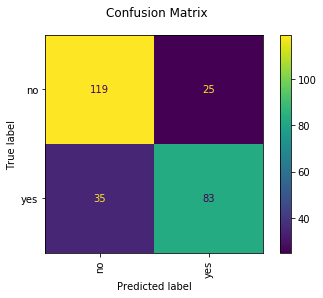

In [10]:
# plot confusion matrix
disp = plot_confusion_matrix(grid_search, X_test, y_test, display_labels=['no', 'yes'], xticks_rotation='vertical')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

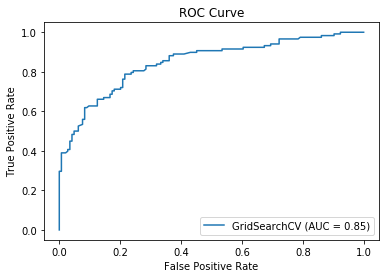

In [11]:
# plot roc curve
disp = plot_roc_curve(grid_search, X_test, y_test)
disp.ax_.set_title('ROC Curve')
#disp = plot_roc_curve(grid_search, X_test, y_test, ax=disp.ax_) # if several models compared
plt.show()

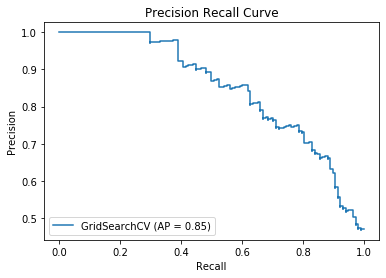

In [12]:
# plot precision recall curve
disp = plot_precision_recall_curve(grid_search, X_test, y_test)
disp.ax_.set_title('Precision Recall Curve')
plt.show()

# Optimal Threshold for ROC Curve

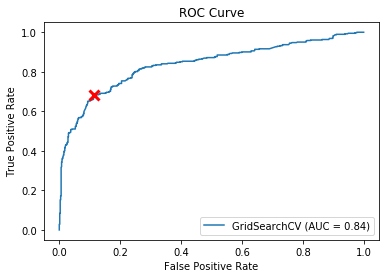

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       144
           1       0.77      0.70      0.73       118

    accuracy                           0.77       262
   macro avg       0.77      0.76      0.77       262
weighted avg       0.77      0.77      0.77       262


              precision    recall  f1-score   support

           0       0.75      0.92      0.82       144
           1       0.86      0.62      0.72       118

    accuracy                           0.78       262
   macro avg       0.80      0.77      0.77       262
weighted avg       0.80      0.78      0.78       262



In [13]:
# calculate probabilities keeping values for the positive outcome only
y_train_prob1 = grid_search.predict_proba(X_train)[:,1]

# calculate roc curves, 
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob1)

# compute scores
scores = np.sqrt( tpr * (1-fpr) ) # g-mean
#scores = np.sqrt( tpr - fpr ) # J statistic

# determine best threshold
idx = scores.argmax()
best_threshold = thresholds[idx]

# plot roc curve
disp = plot_roc_curve(grid_search, X_train, y_train)
disp.ax_.set_title('ROC Curve')
disp.ax_.plot(fpr[idx], tpr[idx], 'rx', markersize=10, mew=3, label='best threshold')
plt.show()

# prediction on test set using best threshold
y_test_prob1 = grid_search.predict_proba(X_test)[:,1].reshape(-1, 1)
y_pred_best_threshold = binarize(y_test_prob1, best_threshold).ravel()

# create classification report
print( classification_report(y_test, y_pred) )
print()
print( classification_report(y_test, y_pred_best_threshold) )

# Optimal Threshold for Precision-Recall Curve

Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classiffier on the positive (minority class) only. It describes how good a model is at predicting the positive class.

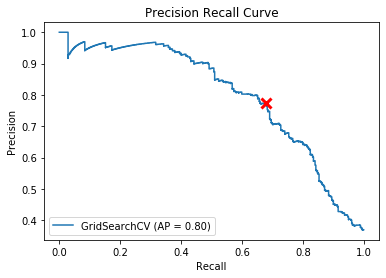

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       144
           1       0.77      0.70      0.73       118

    accuracy                           0.77       262
   macro avg       0.77      0.76      0.77       262
weighted avg       0.77      0.77      0.77       262


              precision    recall  f1-score   support

           0       0.75      0.92      0.82       144
           1       0.86      0.62      0.72       118

    accuracy                           0.78       262
   macro avg       0.80      0.77      0.77       262
weighted avg       0.80      0.78      0.78       262



In [14]:
# calculate probabilities keeping values for the positive outcome only
y_train_prob1 = grid_search.predict_proba(X_train)[:,1]

# calculate precision recall
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob1)

# compute the F1 score
fscore = 2 * (precision * recall) / (precision + recall)

# determine best threshold
idx = fscore.argmax()
best_threshold = thresholds[idx]

# plot precision recall curve
disp = plot_precision_recall_curve(grid_search, X_train, y_train)
disp.ax_.set_title('Precision Recall Curve')
disp.ax_.plot(recall[idx], precision[idx], 'rx', markersize=10, mew=3, label='best threshold')
plt.show()

# prediction on test set using best threshold
y_test_prob1 = grid_search.predict_proba(X_test)[:,1].reshape(-1, 1)
y_pred_best_threshold = binarize(y_test_prob1, best_threshold).ravel()

# create classification report
print( classification_report(y_test, y_pred) )
print()
print( classification_report(y_test, y_pred_best_threshold) )

In [15]:
y_train_prob1.shape

(1047,)